In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
file = pd.read_csv('insurance.csv')

print(file.info())
print(file.shape)

file.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
file.duplicated().any()
file =file.drop_duplicates()

In [3]:
file.sample(5)

,age,sex,bmi,children,smoker,region,charges
922,38,male,31.000,1,no,southwest,5488.26200
1198,40,male,29.355,1,no,northwest,6393.60345
106,19,female,28.400,1,no,southwest,2331.51900
1315,18,male,28.310,1,no,northeast,11272.33139
1151,58,female,36.480,0,no,northwest,12235.83920


In [4]:
file =file.drop_duplicates().reset_index()
file.shape

(1337, 8)

<AxesSubplot:>

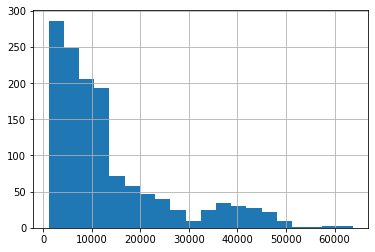

In [5]:
file['charges'].hist(bins=20)

<AxesSubplot:>

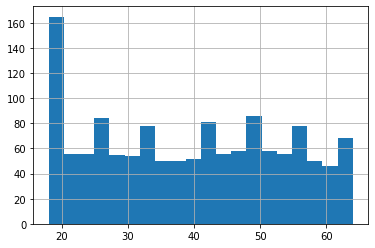

In [6]:
file['age'].hist(bins=20)

<AxesSubplot:>

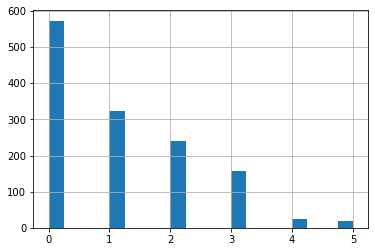

In [7]:
file['children'].hist(bins=20)

In [8]:
file[['sex', 'charges']].groupby(by='sex').mean()

,charges
sex,
female,12569.578844
male,13974.998864


In [9]:
file[['smoker', 'charges']].groupby(by='smoker').mean()

,charges
smoker,
no,8440.660307
yes,32050.231832


In [10]:
file[['smoker', 'charges']].groupby(by='smoker').describe()

charges                                                        \
         count          mean           std         min           25%   
smoker                                                                 
no      1063.0   8440.660307   5992.973800   1121.8739   3988.883500   
yes      274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                                                
                50%           75%          max  
smoker                                          
no       7345.72660  11363.019100  36910.60803  
yes     34456.34845  41019.207275  63770.42801

In [11]:
file[['children', 'charges']].groupby(by='children').mean('charges').sort_values(by='charges', ascending=False)

,charges
children,
3,15355.318367
2,15073.563734
4,13850.656311
1,12731.171832
0,12384.695344
5,8786.035247


In [12]:
file['user_ID'] = pd.DataFrame(file.index).astype(int)
file = file[['user_ID', 'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']]
file

# file_feat_transp_count = pd.DataFrame(file_feat_transp[file_feat_transp[col]].sum())

,user_ID,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1332,1332,50,male,30.970,3,no,northwest,10600.54830
1333,1333,18,female,31.920,0,no,northeast,2205.98080
1334,1334,18,female,36.850,0,no,southeast,1629.83350
1335,1335,21,female,25.800,0,no,southwest,2007.94500


In [13]:
df_user = (
    file[['user_ID', 'charges']]
    .groupby('user_ID')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_user['cumsum'] = df_user['total_charges'].cumsum()
value_80proc = int(df_user['total_charges'].sum()*0.8)
df_user['top_user'] = df_user['cumsum'] > value_80proc

top_user = set(df_user[df_user['top_user']]['user_ID'])
len(top_user)/file['user_ID'].nunique()

0.5205684367988033

In [14]:
df_user

,user_ID,total_charges,cumsum,top_user
543,543,63770.42801,6.377043e+04,False
1299,1299,62592.87309,1.263633e+05,False
1229,1229,60021.39897,1.863847e+05,False
577,577,58571.07448,2.449558e+05,False
818,818,55135.40209,3.000912e+05,False
...,...,...,...,...
22,22,1137.01100,1.774966e+07,True
662,662,1136.39940,1.775080e+07,True
1243,1243,1135.94070,1.775193e+07,True
807,807,1131.50660,1.775306e+07,True


In [15]:
df_user_worst = (
    file[['user_ID', 'charges']]
    .groupby('user_ID')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_user_worst['cumsum'] = df_user_worst['total_charges'].cumsum()
value_80proc = int(df_user_worst['total_charges'].sum()*0.8)
df_user_worst['undesirable_user'] = df_user_worst['cumsum'] < value_80proc


In [16]:
df_user_worst=df_user_worst[['user_ID', 'undesirable_user']]
df_user_worst = df_user_worst.merge(file, on='user_ID')
df_user_worst = df_user_worst[df_user_worst['undesirable_user'] ==True]
df_user_worst

,user_ID,undesirable_user,age,sex,bmi,children,smoker,region,charges
0,543,True,54,female,47.410,0,yes,southeast,63770.42801
1,1299,True,45,male,30.360,0,yes,southeast,62592.87309
2,1229,True,52,male,34.485,3,yes,northwest,60021.39897
3,577,True,31,female,38.095,1,yes,northeast,58571.07448
4,818,True,33,female,35.530,0,yes,northwest,55135.40209
...,...,...,...,...,...,...,...,...,...
636,682,True,53,male,24.320,0,no,northwest,9863.47180
637,527,True,51,female,25.800,1,no,southwest,9861.02500
638,279,True,51,female,21.560,1,no,southeast,9855.13140
639,1027,True,54,male,31.600,0,no,southwest,9850.43200


In [17]:
df_user = df_user[['user_ID', 'top_user']]
file = file.merge(df_user, on='user_ID')
file =file[file['top_user'] ==True]
file

,user_ID,age,sex,bmi,children,smoker,region,charges,top_user
1,1,18,male,33.77,1,no,southeast,1725.5523,True
2,2,28,male,33.00,3,no,southeast,4449.4620,True
4,4,32,male,28.88,0,no,northwest,3866.8552,True
5,5,31,female,25.74,0,no,southeast,3756.6216,True
6,6,46,female,33.44,1,no,southeast,8240.5896,True
...,...,...,...,...,...,...,...,...,...
1325,1325,42,female,32.87,0,no,northeast,7050.0213,True
1326,1326,51,male,30.03,1,no,southeast,9377.9047,True
1333,1333,18,female,31.92,0,no,northeast,2205.9808,True
1334,1334,18,female,36.85,0,no,southeast,1629.8335,True


In [18]:
df_children = (
    file[['children', 'charges']]
    .groupby('children')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_children['cumsum'] = df_children['total_charges'].cumsum()
value_80proc = int(df_children['total_charges'].sum()*0.8)
df_children['top_children'] = df_children['cumsum'] > value_80proc

top_children = set(df_children[df_children['top_children']]['children'])
df_children = df_children[['children', 'top_children']]

In [19]:
len(top_children)/file['children'].nunique()

0.6666666666666666

In [20]:
df_children

,children,top_children
1,1,False
0,0,False
2,2,True
3,3,True
5,5,True
4,4,True


In [21]:
df_smoker = (
    file[['smoker', 'charges']]
    .groupby('smoker')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_smoker['cumsum'] = df_smoker['total_charges'].cumsum()
value_80proc = int(df_smoker['total_charges'].sum()*0.8)
df_smoker['top_smoker'] = df_smoker['cumsum'] > value_80proc

top_smoker= set(df_smoker[df_smoker['top_smoker']]['smoker'])
df_smoker = df_smoker[['smoker', 'top_smoker']]

In [22]:
len(top_smoker)/file['smoker'].nunique()

1.0

In [23]:
df_age = (
    file[['age', 'charges']]
    .groupby('age')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_age['cumsum'] = df_age['total_charges'].cumsum()
value_80proc = int(df_age['total_charges'].sum()*0.8)
df_age['top_age'] = df_age['cumsum'] > value_80proc

top_age= set(df_age[df_age['top_age']]['age'])
df_age[['age', 'top_age']].groupby(by='top_age').describe()
df_age = df_age[['age', 'top_age']]

In [24]:
len(top_age)/file['age'].nunique()

0.3611111111111111

In [25]:
df_sex = (
    file[['sex', 'charges']]
    .groupby('sex')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_sex['cumsum'] = df_sex['total_charges'].cumsum()
value_80proc = int(df_sex['total_charges'].sum()*0.8)
df_sex['top_sex'] = df_sex['cumsum'] > value_80proc

top_sex= set(df_sex[df_sex['top_sex']]['sex'])
df_sex = df_sex[['sex', 'top_sex']]

In [26]:
len(top_sex)/file['sex'].nunique()

0.5

In [27]:
df_bmi = (
    file[['bmi', 'charges']]
    .groupby('bmi')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_bmi['cumsum'] = df_bmi['total_charges'].cumsum()
value_80proc = int(df_bmi['total_charges'].sum()*0.8)
df_bmi['top_bmi'] = df_bmi['cumsum'] > value_80proc

top_bmi= set(df_bmi[df_bmi['top_bmi']]['bmi'])
df_bmi[['bmi', 'top_bmi']].groupby(by='top_bmi').describe()
df_bmi = df_bmi[['bmi', 'top_bmi']]

In [28]:
# len(top_bmi)/file['bmi'].nunique()

In [29]:
df_region = (
    file[['region', 'charges']]
    .groupby('region')
    .agg('sum')
    .reset_index()
    .sort_values(by='charges', ascending=False)
    .rename(columns={'charges':'total_charges'})
)

df_region['cumsum'] = df_region['total_charges'].cumsum()
value_80proc = int(df_region['total_charges'].sum()*0.8)
df_region['top_region'] = df_region['cumsum'] > value_80proc

top_region= set(df_region[df_region['top_region']]['region'])
df_region = df_region[['region', 'top_region']]

In [30]:
len(top_region)/file['region'].nunique()

0.25

In [31]:
file = file.merge(df_region, on='region')
file = file.merge(df_children, on='children')
file = file.merge(df_smoker, on='smoker')
file = file.merge(df_age, on='age')
file = file.merge(df_sex, on='sex')
file = file.merge(df_bmi, on='bmi')
file


,user_ID,age,sex,bmi,children,smoker,region,charges,top_user,top_region,top_children,top_smoker,top_age,top_sex,top_bmi
0,1,18,male,33.770,1,no,southeast,1725.55230,True,False,False,True,False,True,True
1,1096,22,male,33.770,0,no,southeast,1674.63230,True,False,False,True,True,True,True
2,270,18,male,29.370,1,no,southeast,1719.43630,True,False,False,True,False,True,False
3,609,47,female,29.370,1,no,southeast,8547.69130,True,False,False,True,False,False,False
4,709,18,male,35.200,1,no,southeast,1727.54000,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,81,45,female,38.285,0,no,northeast,7935.29115,True,True,False,True,False,False,False
692,445,45,female,33.100,0,no,southwest,7345.08400,True,False,False,True,False,False,False
693,652,45,female,36.300,2,no,southeast,8527.53200,True,False,True,True,False,False,False
694,1233,45,female,27.830,2,no,southeast,8515.75870,True,False,True,True,False,False,False


In [32]:

encoder = LabelEncoder()
file[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'top_user', 'top_region', 'top_children', 'top_smoker', 'top_age', 'top_sex', 'top_bmi']] = file[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'top_user', 'top_region', 'top_children', 'top_smoker', 'top_age', 'top_sex', 'top_bmi' ]].apply(encoder.fit_transform)
#, 'top_user', 'top_region', 'top_children', 'top_smoker', 'top_age', 'top_sex', 'top_bmi'
file = file.drop(columns=['user_ID'])
data_tree = file.copy()
tree_reg = DecisionTreeRegressor(random_state=42, max_leaf_nodes=10) 
x_train, x_test, y_train, y_test = train_test_split(data_tree.drop(columns=["charges"]), data_tree["charges"], test_size=0.3, random_state=42)
tree_reg.fit(x_train,y_train)

DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)

In [33]:
def pred_result(pred,y_test):
  score_MSE = round(mean_squared_error(pred, y_test))
  score_MAE = round(mean_absolute_error(pred, y_test))
  score_r2score = round(r2_score(pred, y_test),2)
  print(f"MSE: {score_MSE} | MAE: {score_MAE} | R2score: {score_r2score}")

In [34]:
tree_pred = tree_reg.predict(x_test)
pred_result(tree_pred, y_test)

MSE: 387450 | MAE: 498 | R2score: 0.94


Feature: 0, Score: 0.94921
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.03818
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.01260
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000


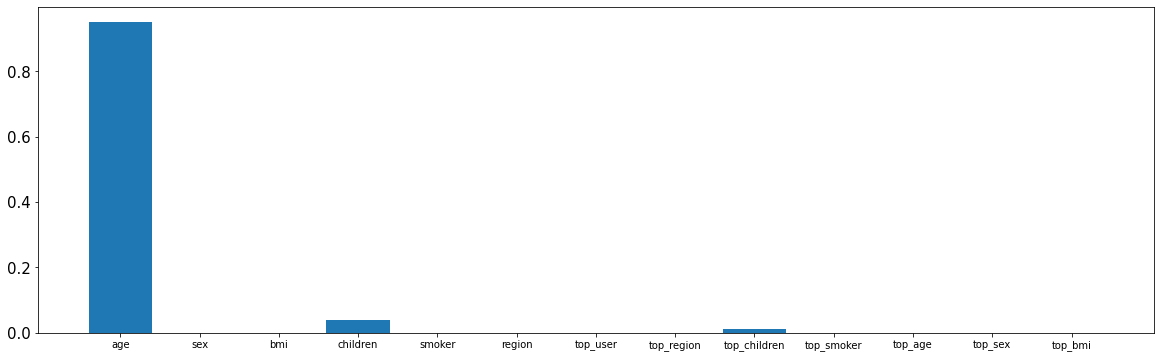

In [35]:
importance = tree_reg.feature_importances_
plt.figure(figsize=(20,6))
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(x_train.columns, importance)
plt.yticks(fontsize=15)
plt.show()

In [36]:
forth_sample = x_test.iloc[4]
print("predicted: ",int(tree_reg.predict([forth_sample.values])))
print("actual: ",int(y_test.iloc[4]))

predicted:  5133
actual:  5472


c:\Users\AMD\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [37]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
from sklearn.tree import plot_tree


[Text(0.4861111111111111, 0.9, 'age <= 14.5\nsquared_error = 6267655.633\nsamples = 487\nvalue = 5177.983'),
 Text(0.2222222222222222, 0.7, 'age <= 6.5\nsquared_error = 1551843.941\nsamples = 246\nvalue = 3098.932'),
 Text(0.1111111111111111, 0.5, 'children <= 1.5\nsquared_error = 941220.484\nsamples = 129\nvalue = 2290.755'),
 Text(0.05555555555555555, 0.3, 'squared_error = 483089.286\nsamples = 108\nvalue = 1991.866'),
 Text(0.16666666666666666, 0.3, 'squared_error = 475091.787\nsamples = 21\nvalue = 3827.894'),
 Text(0.3333333333333333, 0.5, 'top_region <= 0.5\nsquared_error = 710954.853\nsamples = 117\nvalue = 3989.999'),
 Text(0.2777777777777778, 0.3, 'squared_error = 453195.761\nsamples = 74\nvalue = 3567.204'),
 Text(0.3888888888888889, 0.3, 'squared_error = 317513.071\nsamples = 43\nvalue = 4717.599'),
 Text(0.75, 0.7, 'age <= 24.5\nsquared_error = 2165501.969\nsamples = 241\nvalue = 7300.169'),
 Text(0.6111111111111112, 0.5, 'age <= 20.5\nsquared_error = 1089287.57\nsamples = 

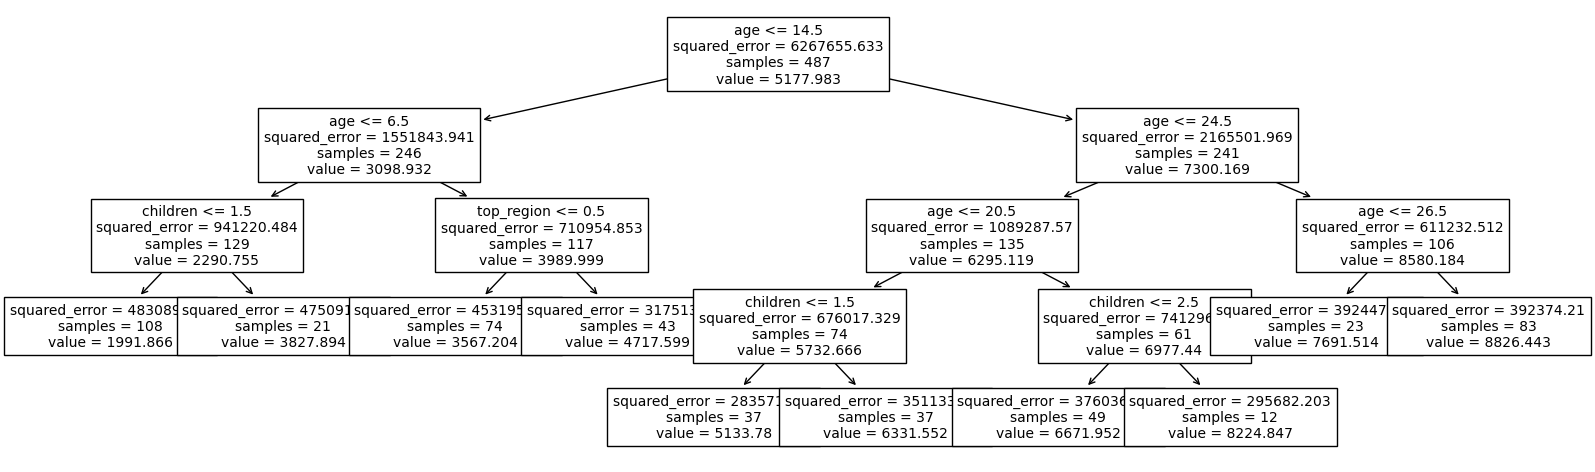

In [38]:
plt.figure(figsize=[20,6], dpi=100)
plot_tree(tree_reg, fontsize=10, feature_names=file.columns)

In [39]:
data = pd.read_csv("insurance.csv")
encoder = LabelEncoder()
data[['age','sex','smoker','region']] = data[['age','sex','smoker','region']].apply(encoder.fit_transform)
data_tree = data.copy()
tree_reg = DecisionTreeRegressor(random_state=42,max_leaf_nodes=10) 
x_train, x_test, y_train, y_test = train_test_split(data_tree.drop(columns=["charges"]), data_tree["charges"], test_size=0.3, random_state=42)
tree_reg.fit(x_train,y_train)

DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)

In [40]:
tree_pred = tree_reg.predict(x_test)
pred_result(tree_pred, y_test)

MSE: 22688344 | MAE: 2864 | R2score: 0.84


Feature: 0, Score: 0.11787
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.17301
Feature: 3, Score: 0.00379
Feature: 4, Score: 0.70533
Feature: 5, Score: 0.00000


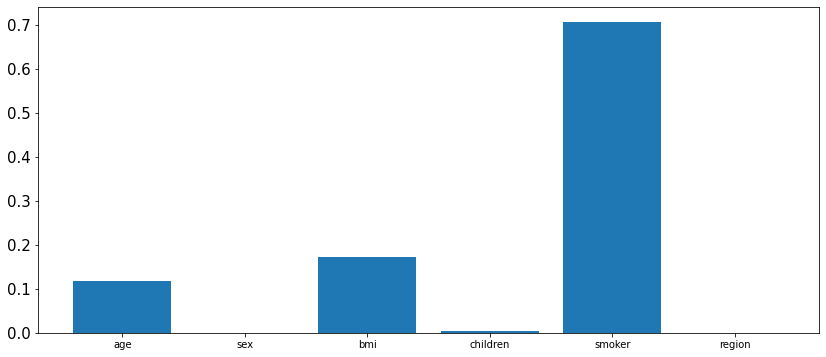

In [41]:
importance = tree_reg.feature_importances_
plt.figure(figsize=(14,6))
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(x_train.columns, importance)
plt.yticks(fontsize=15)
plt.show()

In [42]:
forth_sample = x_test.iloc[4]
print("predicted: ",int(tree_reg.predict([forth_sample.values])))
print("actual: ",int(y_test.iloc[4]))

predicted:  36158
actual:  33750


c:\Users\AMD\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


[Text(0.5, 0.9166666666666666, 'smoker <= 0.5\nsquared_error = 146468393.299\nsamples = 936\nvalue = 13379.157'),
 Text(0.25, 0.75, 'age <= 24.5\nsquared_error = 37221997.558\nsamples = 741\nvalue = 8542.875'),
 Text(0.125, 0.5833333333333334, 'age <= 4.5\nsquared_error = 21618064.588\nsamples = 413\nvalue = 5409.331'),
 Text(0.0625, 0.4166666666666667, 'squared_error = 19696578.22\nsamples = 121\nvalue = 3233.463'),
 Text(0.1875, 0.4166666666666667, 'squared_error = 19639476.63\nsamples = 292\nvalue = 6310.975'),
 Text(0.375, 0.5833333333333334, 'age <= 34.5\nsquared_error = 28938262.494\nsamples = 328\nvalue = 12488.466'),
 Text(0.3125, 0.4166666666666667, 'squared_error = 24342176.216\nsamples = 148\nvalue = 10595.861'),
 Text(0.4375, 0.4166666666666667, 'age <= 40.5\nsquared_error = 27350528.287\nsamples = 180\nvalue = 14044.608'),
 Text(0.375, 0.25, 'squared_error = 22672890.557\nsamples = 104\nvalue = 12922.211'),
 Text(0.5, 0.25, 'children <= 3.5\nsquared_error = 29668581.022\ns

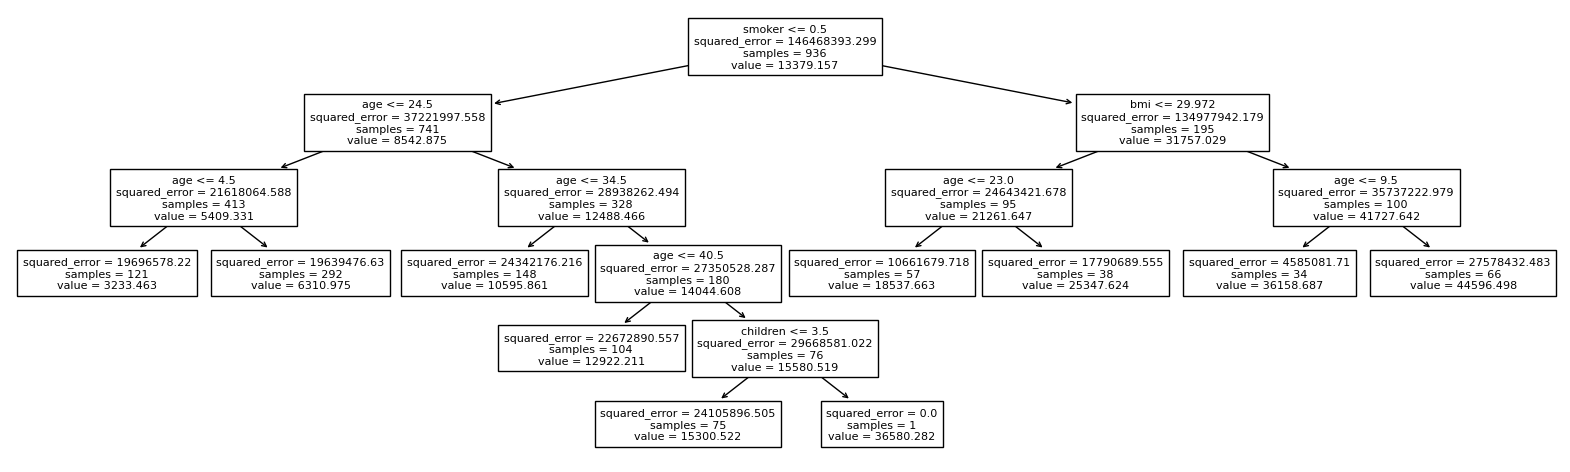

In [43]:
plt.figure(figsize=[20,6], dpi=100)
plot_tree(tree_reg, fontsize=8, feature_names=['age','sex', 'bmi', 'children', 'smoker','region'])

In [44]:
import seaborn as sns

In [45]:
def model_summary(y_test,tree_pred,title="Title"):
    sns.set(rc={'figure.figsize':(10,10)})
    max1 = tree_pred.max()
    max2 = y_test.max()
    m = min(max1,max2)
    plt.scatter(y_test,tree_pred)
    plt.xlabel("test values")
    plt.ylabel("prediceted values")
    plt.plot([0,m],[0,m],'r--')
    mae = mean_absolute_error(y_test, tree_pred)
    r2 = r2_score(y_test, tree_pred)
    rmse = mean_squared_error(y_test, tree_pred, squared=False)
    plt.title(str(title).upper(), font={'size':16})
    t1, t2, t3, t4 = "Mean:", "RMSE:", "MAE:", "R^2:"
    s1, s2, s3, s4 = format(tree_pred.mean(),'.3f'), format(rmse,'.3f'), format(mae,'.3f'), format(r2,'.3f')
    plt.annotate(f"{t1} {s1:>10} \n{t2} {s2:>10} \n{t3} {s3:>11} \n{t4} {s4:>11}", [0,max1*.9],
                    font={'size':13, 'family':'courier new', 'weight':'bold'},
                    bbox={'facecolor': 'white', 'edgecolor' : 'black', 'alpha': 0.5, 'pad': 10})

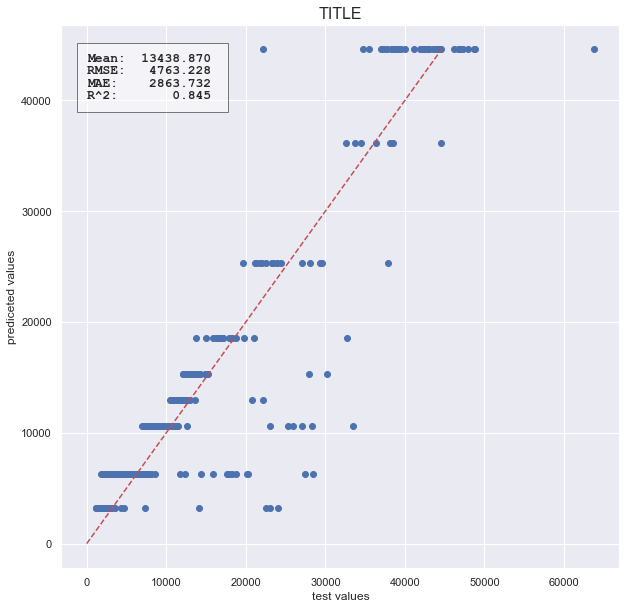

In [46]:
model_summary(y_test,tree_pred,title="Title")